1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.
    - 텍스트 이미지 리사이징, ctc loss 측정을 위한 라벨 인코딩, 배치처리 등이 적절히 수행되었다.
2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었다.
    - 학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.
3. keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.
    - 샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.

In [10]:
import tensorflow as tf
import numpy as np
import os
import six
import re
import math
from PIL import Image
import lmdb
import cv2
import keras_ocr
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [11]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

In [12]:
BATCH_SIZE = 128
HOME_DIR = 'C:/Users/ZAKAR/Documents/GitHub/AIFFEL/Exploration/Going_Deeper_CV/OCR'
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

TRAIN_DATA_PATH = HOME_DIR + '/data/training/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR + '/data/training/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR + '/data/training/MJ/MJ_test'

detector = keras_ocr.detection.Detector()

Looking for C:\Users\ZAKAR\.keras-ocr\craft_mlt_25k.h5


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


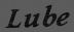

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


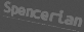

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


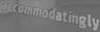

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


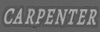

In [13]:
env = lmdb.open(TRAIN_DATA_PATH,
                max_readers=32,
                readonly=True,
                lock=False,
                readahead=False,
                meminit=False)

with env.begin(write=False) as txn:
    for index in range(1, 5):
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        try:
            img = Image.open(buf).convert('RGB')
        
        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
        
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))

        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
   
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [14]:
class MJDatasetSequence(tf.keras.utils.Sequence):

    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)

            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    def __getitem__(self, idx):

        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)

            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [15]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [16]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [17]:
def ctc_lambda_func(args):
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [18]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

In [26]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [27]:
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

ckp = ModelCheckpoint(filepath=checkpoint_path, 
                      monitor='val_loss', 
                      verbose=1, 
                      save_best_only=True, 
                      save_weights_only=True)

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=10, 
                          verbose=0, 
                          mode='auto', 
                          baseline=None, 
                          restore_best_weights=False)


model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/20
565/565 [==============================] - ETA: 0s - loss: 25.4589
Epoch 1: val_loss improved from inf to 24.57453, saving model to C:/Users/ZAKAR/Documents/GitHub/AIFFEL/Exploration/Going_Deeper_CV/OCR\model_checkpoint.hdf5
565/565 [==============================] - 65s 108ms/step - loss: 25.4589 - val_loss: 24.5745
Epoch 2/20
565/565 [==============================] - ETA: 0s - loss: 14.2410
Epoch 2: val_loss improved from 24.57453 to 8.80825, saving model to C:/Users/ZAKAR/Documents/GitHub/AIFFEL/Exploration/Going_Deeper_CV/OCR\model_checkpoint.hdf5
565/565 [==============================] - 61s 108ms/step - loss: 14.2410 - val_loss: 8.8083
Epoch 3/20
565/565 [==============================] - ETA: 0s - loss: 6.8181
Epoch 3: val_loss improved from 8.80825 to 6.30560, saving model to C:/Users/ZAKAR/Documents/GitHub/AIFFEL/Exploration/Going_Deeper_CV/OCR\model_checkpoint.hdf5
565/565 [==============================] - 60s 106ms/step - loss: 6.8181 - val_loss: 6.3056
Epoch 4

In [28]:
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

1/1 [==============================] - 1s 829ms/step
Result: 	 SLINKING9999999999999999


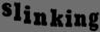

1/1 [==============================] - 0s 68ms/step
Result: 	 ALEPPO99999999999999999


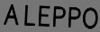

1/1 [==============================] - 0s 58ms/step
Result: 	 FWONDE999999999999999999


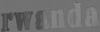

1/1 [==============================] - 0s 45ms/step
Result: 	 NATHANS99999999999999999


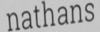

1/1 [==============================] - 0s 32ms/step
Result: 	 HALLO999999999999999999


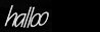

1/1 [==============================] - 0s 34ms/step
Result: 	 HURLS9999999999999999999


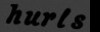

1/1 [==============================] - 0s 32ms/step
Result: 	 DOWNSIZE9999999999999999


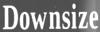

1/1 [==============================] - 0s 32ms/step
Result: 	 ROBOTIC99999999999999999


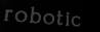

1/1 [==============================] - 0s 33ms/step
Result: 	 SLOPPY99999999999999999


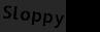

1/1 [==============================] - 0s 32ms/step
Result: 	 HERMITE99999999999999999


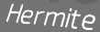

In [29]:
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

In [30]:
from keras_ocr.detection import Detector
import numpy as np
from PIL import ImageDraw


def detect_text(img_path):
    
    detector = Detector()

    img_pil = Image.open(img_path).convert("RGB")
    img = np.array(img_pil)[np.newaxis, ..., ::-1]
    ocr_result = detector.detect(img)
    ocr_result = ocr_result[0]
    img_draw = ImageDraw.Draw(img_pil)

    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return img_pil, cropped_imgs

Looking for C:\Users\ZAKAR\.keras-ocr\craft_mlt_25k.h5
1/1 [==============================] - 1s 852ms/step


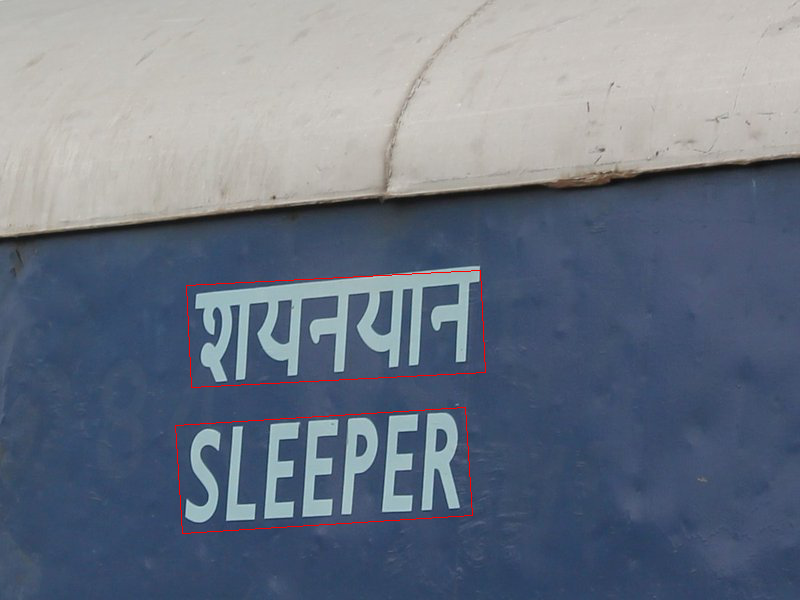

In [32]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

In [66]:
def recognize_img(pil_img, model_input_size=(100,32)):
    output = model_pred.predict(np.expand_dims(np.array(pil_img.resize((100, 32), 3)).transpose(1, 0, 2), axis=0))
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img.resize((100, 32), 3)).astype(np.uint8)))


1/1 [==============================] - 1s 800ms/step
Result: 	 IRTRARUIA999999999999999


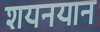

1/1 [==============================] - 0s 57ms/step
Result: 	 ISLEEPER999999999999999


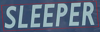

In [67]:
for _img in cropped_img:
    recognize_img(_img)

In [68]:
def end2end_ocr(img_path):
    img_pil, cropped_imgs = detect_text(img_path)
    for img in cropped_imgs:
        recognize_img(img)

Looking for C:\Users\ZAKAR\.keras-ocr\craft_mlt_25k.h5
1/1 [==============================] - 0s 17ms/step
Result: 	 IRTRARUIA999999999999999


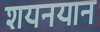

1/1 [==============================] - 0s 19ms/step
Result: 	 ISLEEPER999999999999999


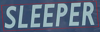

In [70]:
end2end_ocr(SAMPLE_IMG_PATH)